## Library imports, data imports, and initialisations

In [91]:
# Import required libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color = sns.color_palette()
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import norm, probplot

# Load in the training and testing datasets
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

## Data exploration

In [92]:
# Check the size of the datasets
print('Size of the training dataset: {}'.format(df_train.shape))
print('Size of the testing dataset: {}\n'.format(df_test.shape))

# Make sure there are no zero-values in the SalePrice column
df_train['SalePrice'].describe()

Size of the training dataset: (1460, 81)
Size of the testing dataset: (1459, 80)



count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

There are no zero-values, which is great for modelling. However, the results above indicate that there will be a right skew.

Skewness: 1.882876
Kurtosis: 6.536282



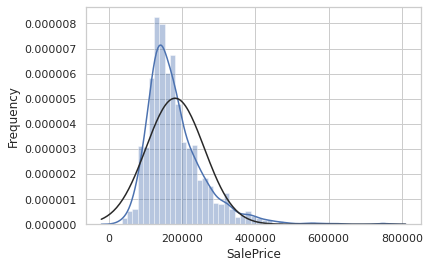

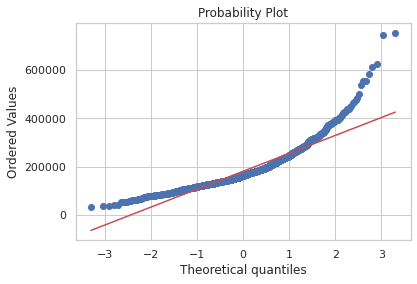

In [93]:
# Fitting params for SalePrice
print('Skewness: %f' % df_train['SalePrice'].skew())
print('Kurtosis: %f\n' % df_train['SalePrice'].kurt())

# Sale price histogram
sns.distplot(df_train['SalePrice'], fit = norm)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.ylabel('Frequency')

# Normal probability plot
fig = plt.figure()
res = probplot(df_train['SalePrice'], plot = plt)
plt.show()

Right skew (positive) confirmed. Noted for later, so that I can apply log transformations to normalise SalePrice.

Characteristics with significant correlations:
GarageArea    GarageCars     0.882475
GarageYrBlt   YearBuilt      0.825667
TotRmsAbvGrd  GrLivArea      0.825489
1stFlrSF      TotalBsmtSF    0.819530
dtype: float64



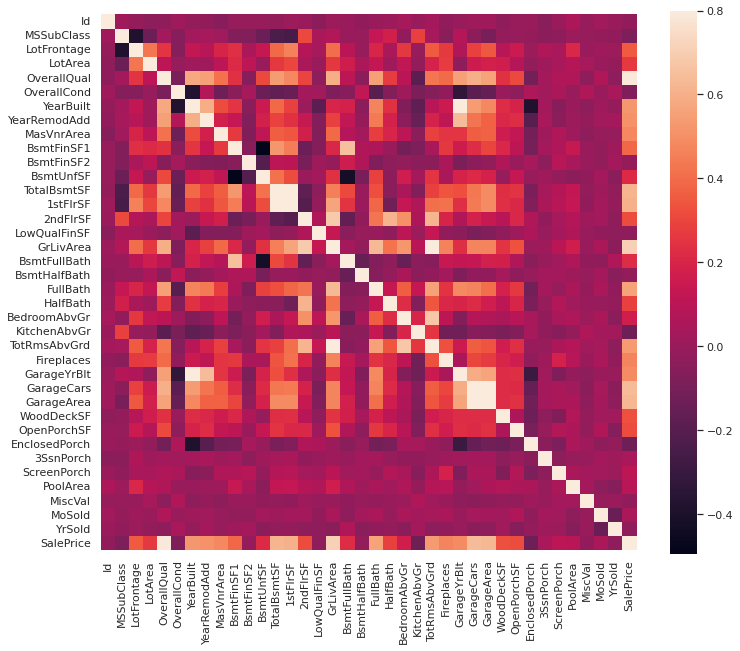

In [94]:
# Correlation matrix for all characteristics
corrMat = df_train.corr()

# Determine which correlations are significant, and drop the others
corrValues = corrMat.unstack().abs()
c = [corrValues.drop(i, inplace = True) for i, v in corrValues.items()
     if i[0] == i[1]                           # left and right index are the same
     or v < 0.8                                # Value is insignificant
     or (i[1], i[0]) in corrValues.index]      # repeated correlation values

# Sort and print the correlation values
print('Characteristics with significant correlations:\n{}\n'.format(corrValues.sort_values(ascending = False)))

# Print the figure
sns.set(font_scale = 1.0, rc = {'figure.figsize': (12, 10)})
sns.heatmap(corrMat, vmax = 0.8, square = True)

Very strong correlations between the following:
* GarageArea & GarageCars
* GarageYrBlt & YearBuilt
* TotRmsAbvGrd & GrLivArea
* 1stFlrSF & TotalBsmtSF

I'll check which characteristic in each of the above pairs has a stronger correlation with SalePrice, and remove the other column.

Characteristics with correlation values over 0.5:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64



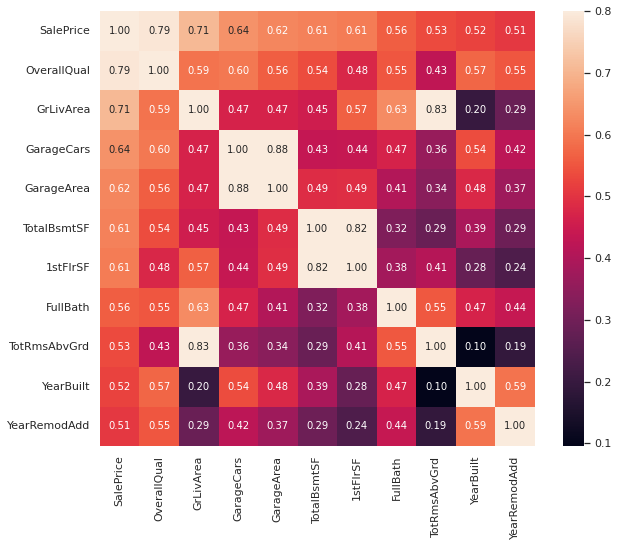

In [95]:
# Saleprice correlation matrix
#     Only including characteristics with the top k corr values

corrMin = 0.5
corrSalePrice = corrMat[corrMat['SalePrice'].abs() >= corrMin]['SalePrice'].sort_values(ascending = False)
print('Characteristics with correlation values over {}:\n{}\n'.format(corrMin, corrSalePrice.drop('SalePrice')))

k = len(corrSalePrice)
cols = corrMat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)

sns.set(font_scale = 1.0, rc = {'figure.figsize': (10, 8)})
sns.heatmap(cm, cbar = True, annot = True, square = True,
            fmt = '0.2f', annot_kws = {'size': 10}, vmax = 0.8,
            xticklabels = cols.values, yticklabels = cols.values)

Referring to the previous strong correlations between characteristics (not inc. SalePrice):
* GarageArea (0.623431) & GarageCars (0.640409)
* GarageYrBlt (less than 0.5)  & YearBuilt (0.522897)
* TotRmsAbvGrd (0.533723) & GrLivArea (0.708624)
* 1stFlrSF (0.605852) & TotalBsmtSF (0.613581)

Therefore the following columns will be removed later:
* GarageArea
* GarageYrBlt
* TotRmsAbvGrd
* 1stFlrSF

The following characteristics are worth exploring further:
* Numerical variables
  * GrLivArea
  * GarageCars
  * TotalBsmtSF
  * FullBath

* Categorical variables
  * OverallQual
  * YearBuilt
  * YearRemodAdd

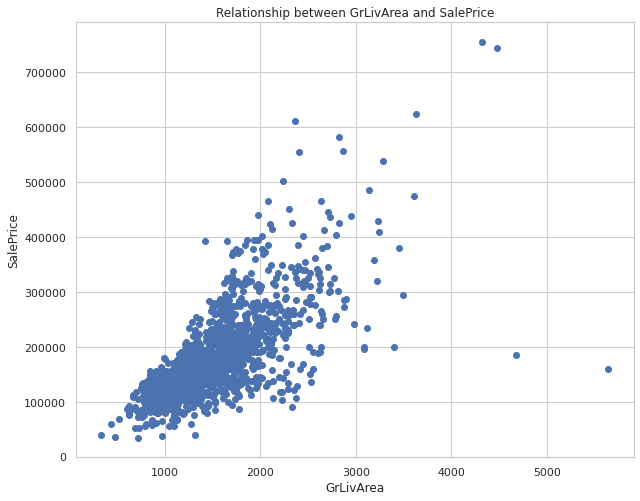

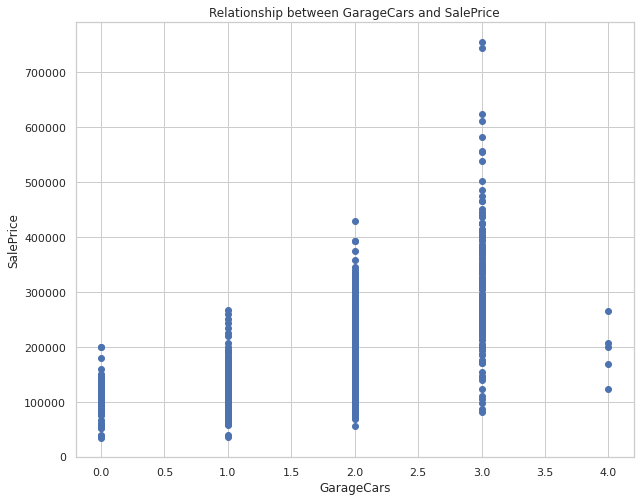

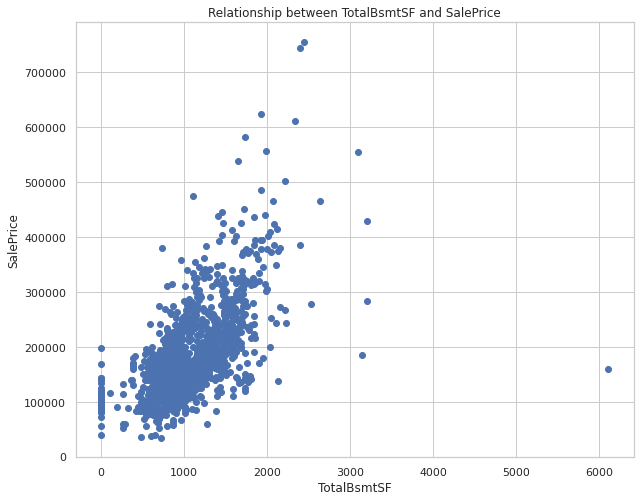

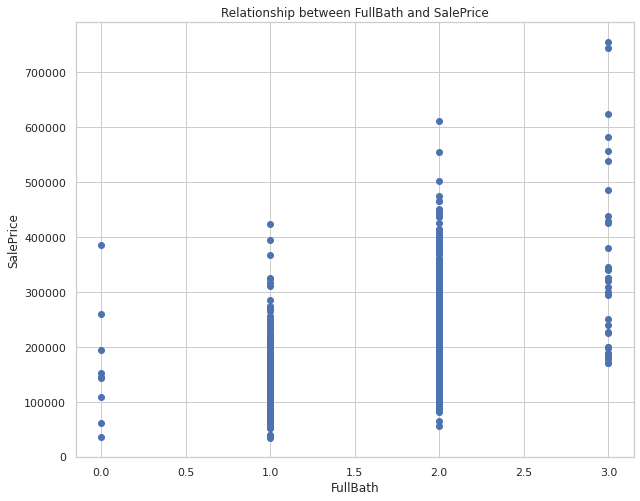

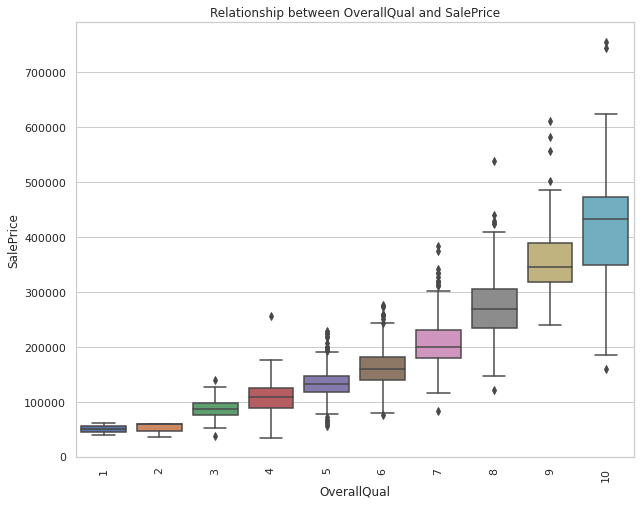

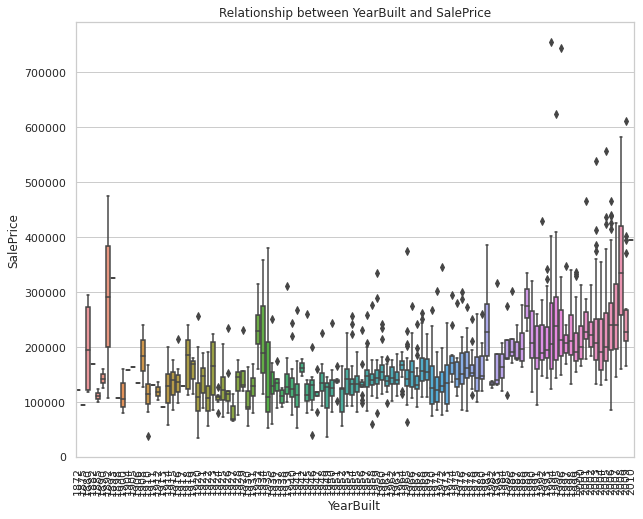

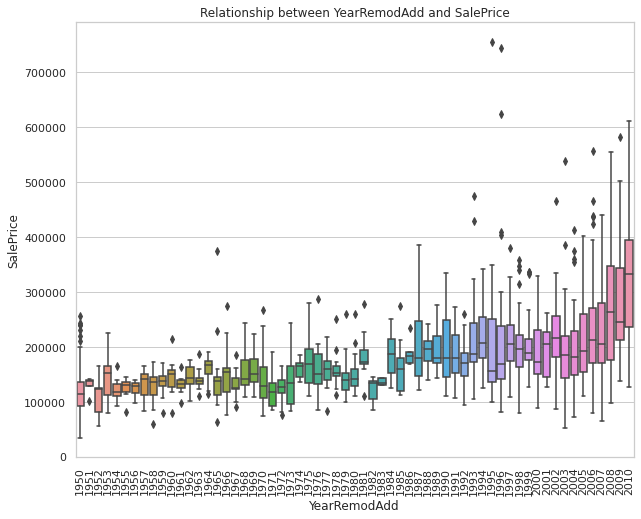

In [136]:
# Fixing Seaborn's styling after it gets reset by the previous correlation matrices
sns.set_style('whitegrid')

# Numerical variables
variables = ['GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath']
for var in variables:
    plt.scatter(x = df_train[var], y = df_train['SalePrice'])
    plt.title('Relationship between {} and {}'.format(var, 'SalePrice'))
    plt.xlabel(var)
    plt.ylabel('SalePrice')
    plt.show()
    
# Numerical variables
variables = ['OverallQual', 'YearBuilt', 'YearRemodAdd']
for var in variables:
    sns.boxplot(x = df_train[var], y = df_train['SalePrice'])
    plt.title('Relationship between {} and {}'.format(var, 'SalePrice'))
    plt.xlabel(var)
    plt.ylabel('SalePrice')
    plt.xticks(rotation = 90)
    plt.show()

The relationships are as expected, though there are a handful of outliers that will likely need to be dealt with. 

* GrLivArea and TotalBsmtSF have obvious outliers to the right of the plot, these will be excluded
* YearBuilt and YearRemodAdd both have outliers near the top of the plot, these may be excluded

I will attend to these outliers (and possibly others) later.